#

# pca, pbe with degree 2, ohe 

### Installing and importing useful libraries

In [1]:
# Standard libraries
import os
import sys
import math
import random
import datetime

# Numerical computing
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set_theme()

#importing optimization techniques
from implementations import *
from helpers import *

### Importing data

In [ ]:

base_path = os.path.join("data", "dataset")

# File paths
x_train_path = os.path.join(base_path, "X_train_ohe_pca_pbe_281025.csv")
y_train_path = os.path.join(base_path, "y_train.csv")

# Load the data
x_train = np.loadtxt(x_train_path, delimiter=',', dtype=float, skiprows=1)
y_train = np.loadtxt(y_train_path, delimiter=',', dtype=float, skiprows=1, usecols=1)

# Convert y_train from {-1, 1} to {0, 1}
y_train = np.where(y_train == -1, 0, y_train)

# Print shapes
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)



### Split the data between 20 % validation set and 80 % training set

In [ ]:
def train_val_split(X, y, val_ratio=0.20, seed=42):
    '''
    Function to randomly split the data in a 20% validation set and a 80% training set
    Args : 
            - X (numpy array) dataset input
            - y (numpy array) dataset output
            - val_ratio (float) validation set percentage, default 20%
            - seed (int) random seed
    Returns : 
            - Input train set, input validation set, output train set, output validation set, train indices, validation indices
    '''
    X = np.asarray(X); y = np.asarray(y)
    n = X.shape[0]
    rng = np.random.default_rng(seed)
    idx = np.arange(n)
    rng.shuffle(idx)

    n_val = int(np.round(n * val_ratio))
    val_idx = idx[:n_val]
    train_idx = idx[n_val:]

    return X[train_idx], X[val_idx], y[train_idx], y[val_idx], train_idx, val_idx


# split dataset in validation and train set
x_train_split, x_val_split, y_train_split, y_val_split, tr_idx, va_idx = train_val_split(x_train, y_train, val_ratio=0.20, seed=42)
print(x_train_split.shape)
print(x_val_split.shape)


(262508, 576)
(65627, 576)


### Hyperparameters definition and metrics

In [ ]:
lambdas = [ 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]  # regularization parameters list
gammas = [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1] # step-size parameters list
max_iters = [100] # max iters list
k_folds = 5


def compute_auc(y_true, y_scores):
    """
    AUC calculation using Mann-Whitney statistics
    Inputs : 
            - y_true : numpy array containing the real {0, 1} values of the dataset
            - y_scores : numpy array containing our predictions
    Output : 
            AUC Area under the ROC curve 
    """
    order = np.argsort(y_scores)
    y_true_sorted = y_true[order]

    n_pos = np.sum(y_true)
    n_neg = len(y_true) - n_pos

    # rank positions 
    rank_positions = np.arange(1, len(y_true_sorted) + 1)
    rank_sum = np.sum(rank_positions[y_true_sorted == 1])

    # AUC using Mann–Whitney
    auc = (rank_sum - n_pos*(n_pos+1)/2) / (n_pos * n_neg)
    return auc

def compute_accuracy(y_true, y_scores) : 
    """
    Accuracy computation
    Inputs : 
            - y_true : numpy array containing the real {0, 1} values of the dataset
            - y_scores : numpy array containing our predictions
    Output : 
            Accuracy = correct predictions / total predictions %

    """
    correct_pred = (y_true == y_scores)
    accuracy = np.mean(correct_pred) * 100
    return accuracy

def compute_F1(y_true, y_pred):
    # Convert to boolean arrays
    y_true = np.asarray(y_true).astype(bool)
    y_pred = np.asarray(y_pred).astype(bool)

    # True positives, false positives, false negatives
    tp = np.sum(y_pred & y_true)
    fp = np.sum(y_pred & ~y_true)
    fn = np.sum(~y_pred & y_true)

    # F1 score
    return 2*tp / (2*tp + fp + fn) if (2*tp + fp + fn) > 0 else 0
    


### Functions to balance data

In [ ]:
# BALANCING DATA BY UNDERSAMPLING

def undersample(y_train, seed=21):
    """Function to implement balancing of the dataset using undersampling of the majority class
    Inputs : 
            - y_train : (numpy array) output train datatset
            - seed : (int) randomization seed
    """
    rng = np.random.default_rng(seed)
    classes, counts = np.unique(y_train, return_counts=True)
    maj = classes[np.argmax(counts)]
    min_ = classes[np.argmin(counts)]

    maj_idx = np.flatnonzero(y_train == maj)
    min_idx = np.flatnonzero(y_train == min_)

    n = len(min_idx)
    sampled_maj = rng.choice(maj_idx, size=n, replace=False)
    balanced_idx = np.concatenate((sampled_maj, min_idx))
    rng.shuffle(balanced_idx)
    return balanced_idx

#BALANCING DATA BY OVERSAMPLING
def oversample(y_train, seed=21):
    """Function to implement balancing of the dataset using oversampling of the minority class
    Inputs : 
            - y_train : (numpy array) output train datatset
            - seed : (int) randomization seed
    """
    rng = np.random.default_rng(seed)
    classes, counts = np.unique(y_train, return_counts=True)
    maj_class = classes[np.argmax(counts)]
    min_class = classes[np.argmin(counts)]

    maj_idx = np.flatnonzero(y_train == maj_class)
    min_idx = np.flatnonzero(y_train == min_class)

    # sample minority indexes to be equal to the majority class
    sampled_min_idx = rng.choice(min_idx, size=len(maj_idx), replace=True)
    balanced_idx = np.concatenate((maj_idx, sampled_min_idx))
    rng.shuffle(balanced_idx)
    return balanced_idx


### K-fold cross validation with oversampling and undersampling dataset

In [ ]:
import implementations
import importlib
importlib.reload(implementations)
from implementations import *
import gc

w_initial, _ = ridge_regression(y_train_split, x_train_split, lambda_=0.001) # to make the k-cross faster, we start by a better guess

def build_k_indices(N, k_fold, seed=21): 
    """build k indices for k-fold. 
        Args: N: num of samples 
              k_fold: K in K-fold, i.e. the fold num 
              seed: the random seed 
        Returns: 
              A 2D array of shape=(k_fold, N/k_fold) that indicates the data indices for each fold 
    """
    num_row = N 
    interval = int(num_row / k_fold) 
    np.random.seed(seed) 
    indices = np.random.permutation(num_row) 
    k_indices = [indices[k * interval : (k + 1) * interval] for k in range(k_fold)] 
    return np.array(k_indices)
     

def k_fold_cross_validation(y_train, x_train, lambdas, gammas, max_iters, k_fold, methods, w_initial, seed, undersampling = False, oversampling = True) :
    """
    Function to perform a k-cross validation between different models - L2-regularized logistic regression with gradient descent, 
    least squares, L2-regularized logistic regression with Adam, ridge regression, Linear regression with SGD and GD - in order to find the best one to make predictions on our dataset. We use AUC 
    as metric to rank the models

    Args : 
            - y_train (numpy array) output train dataset
            - x_train (numpy array) input train dataset
            - lambdas (list)  hyperparameters regularization term
            - gammas (list) step-sizes
            - max_iters (list) maximum iterations to perform in the optimization algorithm 
            - k_fold (int) number of folds to per perform k-cross
            - methods (list) methods to apply to reach the optimum parameters w_opt
            - seed (int) random seed
            - undersampling (boolean) k-cross will perform data balancing by undersampling the majority class or not 
            - oversampling (boolena)  k-cross will perform data balancing by oversampling the minority class or not 
    Returns:
            - results (list of dictionaries) contains for each method the best lambda, gamma, max_iter and their corresponding train loss, test loss , AUC, accuracy, predictions and optimum weights 
                        vector
            - best_overall (dictionary) contains the best method wrt AUC and its corresponding lambda, gamma, max_iter, train loss, test loss, AUC, accuracy, predictions, optimum weights vector



    """
    

    # Precompute train/test sets for each fold 
    k_idx = build_k_indices(len(y_train), k_fold, seed)
    N = len(y_train)

    fold_index_pairs=[]
    for k in range(k_fold):
        test_idx = k_idx[k]
        mask = np.ones(N, dtype=bool); mask[test_idx] = False
        train_idx = np.flatnonzero(mask)

        y_train_k = y_train[train_idx]  
        if undersampling:
            rel_idx = undersample(y_train_k, seed)
        elif oversampling:
            rel_idx = oversample(y_train_k, seed)
        else:
            rel_idx = np.arange(len(train_idx))


        train_bal_idx = train_idx[rel_idx] 
        fold_index_pairs.append((train_bal_idx, test_idx))


    # Dictionary to contain the best method with the best parameters and its metrics
    best_overall = {"method": "", "lambda_": 0, "gamma": 0, "max_iter": 0, 
                    "train_loss": 0, "test_loss": 0, "AUC": 0,"F1_score":0,  "accuracy": 0}
    results =[] # to keep the best results per method

    # Define which hyperparameters matter per method
    method_params = {
        "ridge_regression":        ["lambda_"],
        "least_squares":           [],
        "mean_squared_error_gd":   ["gamma", "max_iter"],
        "mean_squared_error_sgd":  ["gamma", "max_iter"],
        "reg_logistic_regression": ["lambda_", "gamma", "max_iter"],
        "adam_reg_logistic_regression": ["lambda_", "gamma", "max_iter"]
    }


    # Scroll the hyperparamters to find the best ones per method and overall
    for method in methods :
        params = method_params[method] 
        best_per_method =  {"method": method, "lambda_": 0, "gamma": 0, "max_iter": 0,
                             "train_loss": 0, "test_loss": 0, "AUC": 0,"F1_score":0, "accuracy": 0} 
        # determine valid search space
        lam_space  = lambdas if "lambda_" in params else [0]
        gam_space  = gammas  if "gamma"   in params else [0]
        iter_space = max_iters if "max_iter" in params else [1]

        for lam in lam_space : # scroll lambdas
            for gam in gam_space : #scroll gammas
                for max_it in iter_space : #scroll iters ----> model defined at this point
                    loss_tr = []
                    loss_te =[]
                    AUC=  []
                    F1 = []
                    accuracies = []
                    
                    for (train_idx_bal, test_idx) in fold_index_pairs:
                        x_train_k = x_train[train_idx_bal, :]
                        y_train_k = y_train[train_idx_bal]
                        x_test_k = x_train[test_idx, :]
                        y_test_k = y_train[test_idx]

                        #train the model
                        if method == "reg_logistic_regression" :
                            w_opt, loss = reg_logistic_regression_2(y_train_k, x_train_k,lam, w_initial, max_it, gam)
                        elif method == "least_squares" :
                            w_opt, loss = least_squares(y_train_k, x_train_k)
                        elif method == "adam_reg_logistic_regression":
                            w_opt, loss = reg_logistic_regression_adam(y_train_k, x_train_k, lam, w_initial, max_it, 0.9, 0.999, gam, 700 )
                        elif method == "ridge_regression" :
                            w_opt, loss = ridge_regression(y_train_k, x_train_k, lam)
                        elif method=="mean_squared_error_gd":
                            w_opt, loss = mean_squared_error_gd_2(y_train_k, x_train_k,  w_initial, max_it, gam)
                        elif method=="mean_squared_error_sgd":
                            w_opt, loss = mean_squared_error_sgd_2(y_train_k, x_train_k, w_initial, max_it, gam)

                        #compute metrics 
                        loss_tr.append(loss) 
                        if method in ["adam_reg_logistic_regression", "reg_logistic_regression"]:
                            loss_te.append(compute_logistic_loss(y_test_k, x_test_k, w_opt)) #without penalizing term 
                        else:
                            loss_te.append(compute_mse_loss(y_test_k, x_test_k, w_opt))
                        
                        if method in ["reg_logistic_regression", "adam_reg_logistic_regression"]:
                            y_score = sigmoid(x_test_k @ w_opt) 
                        else:
                            y_score = x_test_k @ w_opt 
                        y_pred = np.where(y_score >=0.5, 1, 0)
                        AUC.append(compute_auc(y_test_k, y_score))
                        accuracies.append(compute_accuracy(y_test_k, y_pred))
                        F1.append(compute_F1(y_test_k, y_pred))

                        del x_train_k, y_train_k, x_test_k, y_test_k
                        gc.collect()

                    # update
                    mean_AUC = np.mean(AUC)    
                    if mean_AUC > best_per_method["AUC"]:
                        best_per_method.update({"method": method, "gamma": gam, "lambda_": lam, "max_iter": max_it, "train_loss": np.mean(loss_tr), "test_loss": np.mean(loss_te), "AUC": np.mean(AUC), "F1_score": np.mean(F1), "accuracy": np.mean(accuracies)})

                    if mean_AUC > best_overall["AUC"]:
                        best_overall.update(best_per_method)
        results.append(best_per_method)
        print(f"{method}: best λ={best_per_method['lambda_']},  γ={best_per_method['gamma']},  "
              f"iters={best_per_method['max_iter']},  accuracy={best_per_method['accuracy']:.5f} , "
              f"AUC={best_per_method['AUC']:.5f},  F1={best_per_method['F1_score']:.5f}")



    
    print(f"\nBest model overall: {best_overall['method']}  "
          f"(AUC={best_overall['AUC']:.5f}, accuracy={best_overall['accuracy']:.5f})")



    return best_overall, results 

        
methods=["reg_logistic_regression", "least_squares", "adam_reg_logistic_regression", "ridge_regression", "mean_squared_error_gd", "mean_squared_error_sgd" ]










In [ ]:
# Validate with k-cross validation with undersampling and k_folds folds (takes one hour)
best_method_1, results_1 = k_fold_cross_validation(y_train_split, x_train_split, lambdas, gammas, max_iters , k_folds, methods,w_initial, seed = 21, undersampling= True, oversampling=False)

reg_logistic_regression: best λ=0.0001,  γ=0.0001,  iters=100,  accuracy=46.01093 , AUC=0.85475,  F1=0.24163
least_squares: best λ=0,  γ=0,  iters=1,  accuracy=75.56770 , AUC=0.85703,  F1=0.36967
adam_reg_logistic_regression: best λ=0.001,  γ=0.01,  iters=100,  accuracy=76.16655 , AUC=0.84633,  F1=0.36595
ridge_regression: best λ=0.001,  γ=0,  iters=1,  accuracy=75.48123 , AUC=0.85754,  F1=0.36938


c:\Users\sanni\OneDrive\Desktop\POLIMI\EPFL\ML\Project_1\project-1-girl_power\implementations.py:51: RuntimeWarning: overflow encountered in matmul
  return (1 / (2 * N)) * (e.T @ e)
c:\Users\sanni\OneDrive\Desktop\POLIMI\EPFL\ML\Project_1\project-1-girl_power\implementations.py:440: RuntimeWarning: invalid value encountered in scalar subtract
  res = abs(loss_curr - loss_prev)


mean_squared_error_gd: best λ=0,  γ=0.01,  iters=100,  accuracy=75.44352 , AUC=0.85018,  F1=0.36425


c:\Users\sanni\OneDrive\Desktop\POLIMI\EPFL\ML\Project_1\project-1-girl_power\implementations.py:483: RuntimeWarning: invalid value encountered in scalar subtract
  res = abs(loss_curr - loss_prev)


mean_squared_error_sgd: best λ=0,  γ=0.0001,  iters=100,  accuracy=91.03446 , AUC=0.85085,  F1=0.15444

Best model overall: ridge_regression  (AUC=0.85754, accuracy=75.48123)


In [ ]:
# Validate on the best two methods found before, with a better hyperparameters tuning and oversampling, we want to check stability (takes 3 min)
methods = ["least_squares", "ridge_regression"]
lambdas = [1e-5,  1e-4, 1e-3, 1e-2, 1e-1]  # regularization parameters list
gammas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1] # step-size parameters list
max_iters =[100, 300, 600]
best_method_3, results_3 = k_fold_cross_validation(y_train_split, x_train_split, lambdas, gammas, max_iters , k_folds, methods, w_initial, seed = 3, undersampling= False, oversampling=True)

least_squares: best λ=0,  γ=0,  iters=1,  accuracy=75.78903 , AUC=0.85840,  F1=0.37156
ridge_regression: best λ=0.0001,  γ=0,  iters=1,  accuracy=75.74713 , AUC=0.85865,  F1=0.37128

Best model overall: ridge_regression  (AUC=0.85865, accuracy=75.74713)


### Hyperparameters tuning 

#### Ridge regression hyperparameters tuning

In [ ]:
# More precise hyperparameters tuning on the best model 

def log_uniform(low, high, size):
    return 10 ** np.random.uniform(np.log10(low), np.log10(high), size)

# RIDGE REGRESSION 
# center λ=0.0001
ridge_lambdas = log_uniform(2e-5, 7e-4, 15)
print("Ridge λ candidates:", ridge_lambdas)

# K cross ridge with oversampling (takes 6 min)
best_overall_ridge, _ = k_fold_cross_validation(y_train_split, x_train_split, ridge_lambdas, [0], [0], k_folds, ["ridge_regression"], w_initial, 21, False, True)



Ridge λ candidates: [2.00604790e-05 1.55017195e-04 3.26121194e-05 3.51920798e-04
 6.85408357e-04 5.17305927e-04 9.38771615e-05 3.22541491e-04
 1.08396867e-04 2.83497140e-05 1.54171045e-04 3.79842503e-04
 1.61459512e-04 1.63117195e-04 7.34017233e-05]
ridge_regression: best λ=0.00016145951243391507,  γ=0,  iters=1,  accuracy=75.71894 , AUC=0.85857,  F1=0.37135

Best model overall: ridge_regression  (AUC=0.85857, accuracy=75.71894)


In [ ]:
# K cross ridge with center λ=0.00016 more tight
ridge_lambdas = log_uniform(5e-5, 5e-4, 15)
print("Ridge λ candidates:", ridge_lambdas)
# K cross ridge
best_overall_ridge, _ = k_fold_cross_validation(y_train_split, x_train_split, ridge_lambdas, [0], [0], k_folds, ["ridge_regression"], w_initial, 21, False, True)

Ridge λ candidates: [5.00978694e-05 1.88342542e-04 6.86271080e-05 3.20295141e-04
 4.93224882e-04 4.11057078e-04 1.36106719e-04 3.02713041e-04
 1.49392593e-04 6.26757506e-05 1.87676092e-04 3.36531095e-04
 1.93375361e-04 1.94658843e-04 1.16058474e-04]
ridge_regression: best λ=0.00018834254210868702,  γ=0,  iters=1,  accuracy=75.71551 , AUC=0.85857,  F1=0.37137

Best model overall: ridge_regression  (AUC=0.85857, accuracy=75.71551)


In [ ]:
# K cross ridge recentered again 
ridge_lambdas = log_uniform(0.8e-4, 1.9e-4, 15)
print("Ridge λ candidates:", ridge_lambdas)
# K cross ridge
best_overall_ridge, _ = k_fold_cross_validation(y_train_split, x_train_split, ridge_lambdas, [0], [0], k_folds, ["ridge_regression"], w_initial, 21, False, True)

Ridge λ candidates: [8.00587896e-05 1.31663114e-04 9.01059326e-05 1.60728494e-04
 1.89028716e-04 1.76521129e-04 1.16538570e-04 1.57355489e-04
 1.20688278e-04 8.70870711e-05 1.31487903e-04 1.63742039e-04
 1.32973925e-04 1.33304795e-04 1.09767240e-04]
ridge_regression: best λ=0.00016072849373716564,  γ=0,  iters=1,  accuracy=75.71970 , AUC=0.85857,  F1=0.37136

Best model overall: ridge_regression  (AUC=0.85857, accuracy=75.71970)


In [ ]:
# K cross ridge final to check stability (with different seed)
ridge_lambdas = log_uniform(2e-5, 7e-4, 15)
print("Ridge λ candidates:", ridge_lambdas)
# K cross ridge
best_overall_ridge, _ = k_fold_cross_validation(y_train_split, x_train_split, ridge_lambdas, [0], [0], k_folds, ["ridge_regression"], w_initial, 3, False, True)

Ridge λ candidates: [2.00604790e-05 1.55017195e-04 3.26121194e-05 3.51920798e-04
 6.85408357e-04 5.17305927e-04 9.38771615e-05 3.22541491e-04
 1.08396867e-04 2.83497140e-05 1.54171045e-04 3.79842503e-04
 1.61459512e-04 1.63117195e-04 7.34017233e-05]
ridge_regression: best λ=0.00016311719520099738,  γ=0,  iters=1,  accuracy=75.73570 , AUC=0.85867,  F1=0.37126

Best model overall: ridge_regression  (AUC=0.85867, accuracy=75.73570)


### Find the best threshold

In [ ]:
# Define k cross validation function to find the best threshold per method
import numpy as np
import gc

def k_fold_cross_validation_threshold(method, y_train, x_train, k_fold, param_tuple, w_initial,
                                      seeds, undersampling=False, oversampling=False):
    """Find best decision threshold for F1 using multiple seeds and k-fold CV."""
    x_train = x_train.astype(np.float32, copy=False)
    lam, gam, it = param_tuple
    seed_results = []  # store results for each seed

    for seed in seeds:
        k_idx = build_k_indices(len(y_train), k_fold, int(seed))
        N = len(y_train)
        fold_index_pairs = []

        for k in range(k_fold):
            test_idx = k_idx[k]
            mask = np.ones(N, dtype=bool)
            mask[test_idx] = False
            train_idx = np.flatnonzero(mask)

            y_train_k = y_train[train_idx]
            if undersampling:
                rel_idx = undersample(y_train_k, int(seed))
            elif oversampling:
                rel_idx = oversample(y_train_k, int(seed))
            else:
                rel_idx = np.arange(len(train_idx))

            train_bal_idx = train_idx[rel_idx]
            fold_index_pairs.append((train_bal_idx, test_idx))

        F1, accuracies, t_stars, AUC = [], [], [], []

        for (train_idx_bal, test_idx) in fold_index_pairs:
            x_train_k = x_train[train_idx_bal, :]
            y_train_k = y_train[train_idx_bal]
            x_test_k = x_train[test_idx, :]
            y_test_k = y_train[test_idx]

            
            # ridge
            w_opt, _ = ridge_regression(y_train_k, x_train_k, lam)
            y_score = x_test_k @ w_opt

            thresholds = np.linspace(0.1, 0.9, 100)
            f1s = [compute_F1(y_test_k, (y_score >= t).astype(int)) for t in thresholds]
            t_star = thresholds[np.argmax(f1s)]
            best_f1 = np.max(f1s)

            y_pred = (y_score >= t_star).astype(int)
            AUC.append(compute_auc(y_test_k, y_score))
            accuracies.append(compute_accuracy(y_test_k, y_pred))
            F1.append(best_f1)
            t_stars.append(t_star)

            del x_train_k, y_train_k, x_test_k, y_test_k
            gc.collect()

        # per-seed mean
        seed_results.append({
            "seed": int(seed),
            "threshold": float(np.mean(t_stars)),
            "AUC": float(np.mean(AUC)),
            "F1": float(np.mean(F1)),
            "accuracy": float(np.mean(accuracies))
        })

    # aggregate over seeds
    best_threshold = np.mean([r["threshold"] for r in seed_results])
    AUC_mean = np.mean([r["AUC"] for r in seed_results])
    F1_mean = np.mean([r["F1"] for r in seed_results])
    accuracy_mean = np.mean([r["accuracy"] for r in seed_results])

    print(f"\nResults per seed:")
    for r in seed_results:
        print(f" seed={r['seed']:3d} | thr={r['threshold']:.4f} | AUC={r['AUC']:.4f} | "
              f"F1={r['F1']:.4f} | acc={r['accuracy']:.4f}")

    print(f"\nMean results for {method}: thr={best_threshold:.5f} | "
          f"AUC={AUC_mean:.5f} | F1={F1_mean:.5f} | acc={accuracy_mean:.5f}")

    return best_threshold, AUC_mean, F1_mean, accuracy_mean, seed_results

seeds = np.arange(1, 101, 100)  


In [ ]:
# Find the best threshold for Ridge with hyperparamters found through tuning
best_lambda_ridge = 0.00016
best_threshold_ridge , _, _ , _ , _= k_fold_cross_validation_threshold("ridge_regression", y_train_split, x_train_split, 10, (best_lambda_ridge, 0, 0 ), w_initial, seeds, False, False )


Results per seed:
 seed=  1 | thr=0.2099 | AUC=0.8531 | F1=0.4191 | acc=86.2865

Mean results for ridge_regression: thr=0.20990 | AUC=0.85309 | F1=0.41913 | acc=86.28648


### Validation on our validation sample

In [ ]:

# Define validation function
def validation(w_opt, x_val, y_val, method, threshold): 
    if method in ["reg_logistic_regression", "adam_reg_logistic_regression"] :
        
        y_score = sigmoid(x_val @ w_opt) 
    else:
        y_score = x_val @ w_opt
    y_pred = np.where(y_score >=threshold, 1, 0) 
    AUC = compute_auc(y_val, y_score)
    accuracy = compute_accuracy(y_val, y_pred)
    F1 = compute_F1(y_val, y_pred)

    return AUC, accuracy, F1

 

# Retrain optimal models on the whole validation dataset

# Ridge regression
method = "ridge_regression"
w_opt, _ = ridge_regression(y_val_split, x_val_split, best_lambda_ridge) # use best lambda found through k-cross validation
# find best threshold for validation set, just to compare
if method in ["reg_logistic_regression", "adam_reg_logistic_regression"] :
        
        y_score = sigmoid(x_val_split @ w_opt) 
else:
        y_score = x_val_split @ w_opt 

thresholds = np.linspace(0, 1, 101)
best_F1 = 0
best_thresh = 0.5
for t in thresholds:
    y_pred = (y_score >= t).astype(int)
    F1 = compute_F1(y_val_split, y_pred)
    if F1 > best_F1:
        best_F1 = F1
        best_thresh = t
print(f"Best threshold just to compare for validation set (Ridge) is = {best_thresh:.2f}, F1 = {best_F1:.3f}")
# validate
AUC, accuracy, F1 = validation(w_opt, x_val_split, y_val_split,method,  best_threshold_ridge)
print(f"the method ridge regression has an accuracy = {accuracy}, AUC = {AUC}, F1 score = {F1} on our validation set")

Best threshold just to compare for validation set (Ridge) is = 0.21, F1 = 0.426
the method ridge regression has an accuracy = 86.65488289880689, AUC = 0.8558434308425961, F1 score = 0.42593078133193496 on our validation set


### Visualization plot

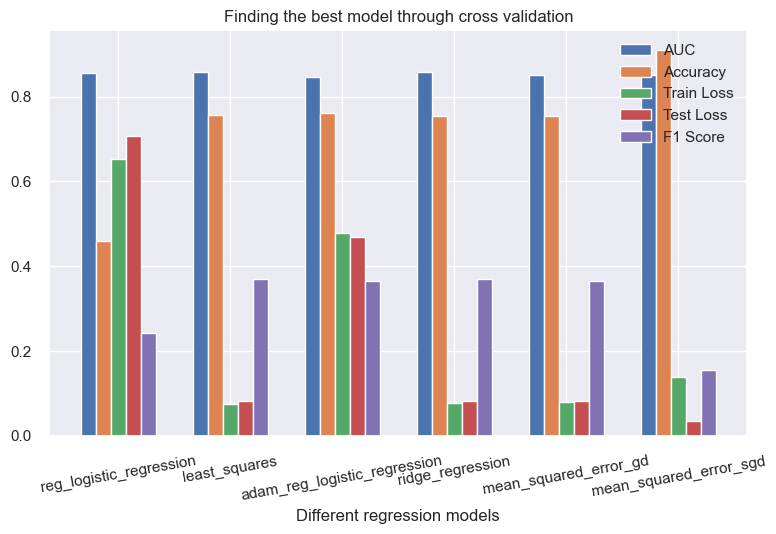

In [ ]:
AUC = []
accuracy = []
loss_tr = []
loss_te = []
F1 = []
methods=["reg_logistic_regression", "least_squares", "adam_reg_logistic_regression", "ridge_regression", "mean_squared_error_gd", "mean_squared_error_sgd" ]

for result in results_1:
    AUC.append(result['AUC'])
    accuracy.append(result['accuracy']/100)
    loss_tr.append(result['train_loss'])
    loss_te.append(result['test_loss'])
    F1.append(result["F1_score"])

num_bars = len(results_1)
w = 0.2  
pos = np.arange(num_bars) * 1.5  

plt.bar(pos - 2*w, AUC, width=w, label='AUC')
plt.bar(pos - w, accuracy, width=w, label='Accuracy')
plt.bar(pos, loss_tr, width=w, label='Train Loss')
plt.bar(pos + w, loss_te, width=w, label='Test Loss')
plt.bar(pos + 2*w, F1, width=w, label='F1 Score')  

plt.xticks(pos, methods, rotation=10)
plt.xlabel('Different regression models')
plt.title('Finding the best model through cross validation')
plt.legend()
plt.tight_layout()
plt.show()


### Precision-recall curve and F1 vs threshold curve

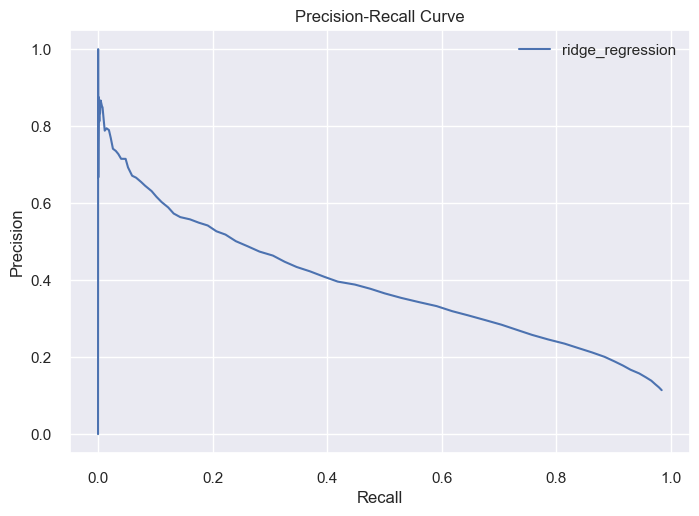

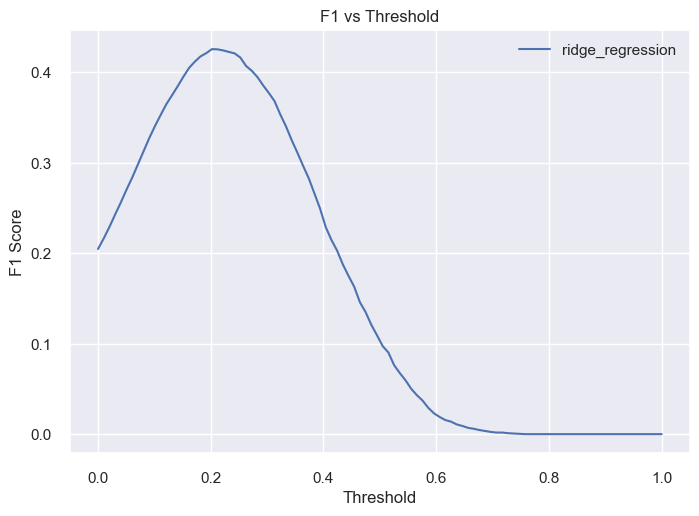

In [ ]:
def plot_precision_recall(y_true, y_score, method):
    thresholds = np.linspace(0, 1, 100)
    precision, recall = [], []
    for t in thresholds:
        y_pred = (y_score >= t).astype(int)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        p = tp / (tp + fp + 1e-9)
        r = tp / (tp + fn + 1e-9)
        precision.append(p)
        recall.append(r)

    plt.plot(recall, precision, label=f"{method}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_f1_vs_threshold(y_true, y_score, method):
    thresholds = np.linspace(0, 1, 100)
    F1s = [compute_F1(y_true, (y_score >= t).astype(int)) for t in thresholds]
    plt.plot(thresholds, F1s, label=f"{method}")
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.title("F1 vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot precision-recall curve
w_opt, _ = ridge_regression(y_val_split, x_val_split, 0.00016 ) # use best lambda found through k-cross validation
y_score = x_val_split @ w_opt 
plot_precision_recall(y_val_split, y_score, "ridge_regression")

# Plot F1 score vs threshold
plot_f1_vs_threshold(y_val_split, y_score, "ridge_regression")


### Test the model and generate the predictions

In [ ]:
Xtest = np.genfromtxt("data/dataset/X_test_preprocessed.csv", delimiter=",", skip_header=1)
test_ids = Xtest[:, 0].astype(int)
print(f"Test IDs: {test_ids[:10]}")

Test IDs: [0 0 0 0 0 0 0 0 0 0]


In [ ]:
import numpy as np
from helpers import create_csv_submission

# Define the prediction function 
def predict(method, X, w_opt, best_threshold):
    """
    Predict using the optimal weights from ridge regression.
    Threshold at 0.5 for binary classification (0 -> -1, 1 -> 1).
    """
    if method == "ridge_regression" :
    # Ridge regression is linear: we use X @ w_opt (dot product)
        y_score = X @ w_opt  # Compute the raw predictions
    elif method == "adam_reg_logistic_regression":
        y_score = sigmoid(X @ w_opt)

    # Apply the threshold to get the final prediction
    y_pred = (y_score >= best_threshold).astype(int)
    y_pred[y_pred == 0] = -1  # Convert 0s to -1 for AIcrowd submission format
    return y_pred

def generate_submission(method, w_opt, X_test_final, best_threshold,  test_ids, out_csv="submission.csv"):
    """
    Generate the submission file using the preprocessed X_test_final and ridge model's optimal weights (w_opt).
    """
    # Generate predictions on X_test_final using w_opt 
    y_pred = predict(method, X_test_final, w_opt, best_threshold)

    # Save the predictions in AIcrowd format
    create_csv_submission(test_ids, y_pred, out_csv)
    print(f"Saved {out_csv} | n={len(y_pred)} | {method} | dims={X_test_final.shape[1]}")

# Load preprocessed X_test_final and test IDs 
X_test_final = np.genfromtxt("data/dataset/X_test_ohe_pca_pbe_281025.csv", delimiter=",", skip_header=1)  # preprocessed test data (already in PCA space)
X_test_raw = np.genfromtxt("data/dataset/x_test.csv", delimiter=",", skip_header=1)
test_ids = X_test_raw[:, 0].astype(int)  # the first column is the ID

w_opt_ridge, _ = ridge_regression(y_val_split, x_val_split, best_lambda_ridge)
#w_opt_adam, _ = reg_logistic_regression_adam(y_val_split, x_val_split, 0.000148516, w_initial, 200, 0.9, 0.999,  0.020932, 700 )

# Call the submission function with the optimal weights 
generate_submission("ridge_regression", w_opt_ridge, X_test_final,best_threshold_ridge, test_ids,  "submission_ridge.csv")
#generate_submission("adam_reg_logistic_regression", w_opt_adam, X_test_final,  best_threshold_adam,test_ids,  "submission_adam.csv")

Saved submission_ridge.csv | n=109379 | ridge_regression | dims=576
